# British Airways Data Science

## Exploratory Data Analysis

This notebook will detail the exploratory data analysis on the cleaned British Airways review data. Before beginning, I have to first strategically understand how I want to utilize the data visualizations/findings to provide value. So, let's start with a series of questions.

- Holistically, what percentage of reviews are considered good or bad? How has this changed over the years?
- What words constitute a good or bad review?
- What are the most common topics referred to by customers?

I would like to note that is mostly an NLP analysis. My goal is to view the text data and cross-reference
with the rating or date.

First, we upload the libraries and run primary checks on the data to see if everything is in order.

In [183]:
import warnings
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import decomposition
from scipy import linalg
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
import sklearn
##from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import scattertext as st
from textblob import TextBlob
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
warnings.filterwarnings("ignore")

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [80]:
pre_data = pd.read_csv('/Users/afifmazhar/Desktop/Data Science/Data Science Projects/British_Airways_Data_Science/data/BA_reviews.csv')
pre_data

,Unnamed: 0,date,rating,body
0,0,8th January 2023,5.0,Not Verified | Great thing about British Airw...
1,1,6th January 2023,1.0,Not Verified | The staff are friendly. The pla...
2,2,2nd January 2023,1.0,✅ Trip Verified | Probably the worst business ...
3,3,2nd January 2023,2.0,"✅ Trip Verified | Definitely not recommended, ..."
4,4,2nd January 2023,8.0,✅ Trip Verified | BA shuttle service across t...
...,...,...,...,...
3443,3443,29th August 2012,10.0,Flew LHR - VIE return operated by bmi but BA a...
3444,3444,28th August 2012,9.0,LHR to HAM. Purser addresses all club passenge...
3445,3445,12th October 2011,5.0,My son who had worked for British Airways urge...
3446,3446,11th October 2011,4.0,London City-New York JFK via Shannon on A318 b...


In [81]:
data = pd.read_csv('/Users/afifmazhar/Desktop/Data Science/Data Science Projects/British_Airways_Data_Science/data/BA_reviews_clean.csv', index_col = 0)
data

,date,rating,body,review
0,2023-01-08,5.0,great thing british airway economy section ups...,Bad
1,2023-01-06,1.0,staff friendly plane cold shivering gave light...,Bad
2,2023-01-02,1.0,probably worst business class experience ive e...,Bad
3,2023-01-02,2.0,definitely recommended especially business cla...,Bad
4,2023-01-02,8.0,shuttle service across uk still surprisingly g...,Good
...,...,...,...,...
3443,2012-08-29,10.0,flew lhr vie return operated bmi aircraft airc...,Good
3444,2012-08-28,9.0,lhr ham purser address club passenger name boa...,Good
3445,2011-10-12,5.0,son worked british airway urged fly british ai...,Bad
3446,2011-10-11,4.0,london citynew york jfk via shannon really nic...,Bad


Now that the data is loaded. I'm going to ask a couple of questions to understand the data. When was the last review given?

In [82]:
data.date.max()

'2023-01-08'

When was the earliest review given?

In [83]:
data.date.min()

'2011-10-09'

How balanced is the data? It may be imbalanced and that might affect if we run a LDA on the topic modeling.

In [199]:
data.review.value_counts()

Bad     2480
Good     968
Name: review, dtype: int64

It seems that there are a lot more bad reviews than good reviews. The imbalance in the data can affect modeling for predictive purposes. Given we are only doing preliminary data analysis, this shouldn't be too much of a problem.

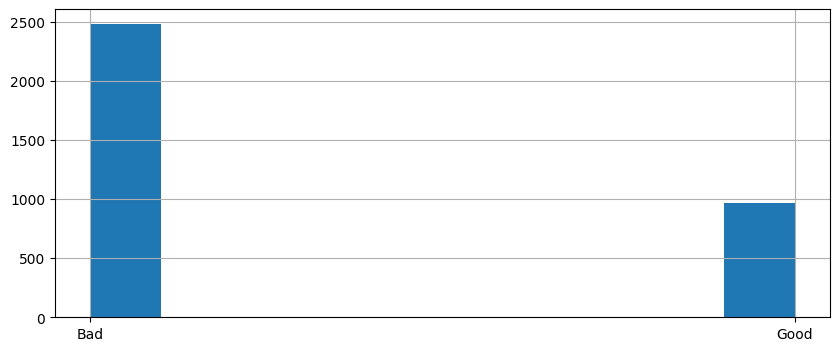

In [85]:
plt.figure(figsize=(10,4))
data['review'].hist()
plt.show()

In [86]:
data['date'] = pd.to_datetime(data['date'])
##data.groupby(data.date.dt.year)['review'].sum()

In [87]:
data.dtypes

date      datetime64[ns]
rating           float64
body              object
review            object
dtype: object

In [88]:
data.groupby(data.date.dt.year)['review'].value_counts()

date  review
2011  Bad         3
2012  Bad         8
      Good        4
2014  Bad       280
      Good      184
2015  Bad       492
      Good      245
2016  Bad       406
      Good      164
2017  Bad       479
      Good       93
2018  Bad       256
      Good       68
2019  Bad       248
      Good      108
2020  Bad        75
      Good       29
2021  Bad        63
      Good       24
2022  Bad       165
      Good       48
2023  Bad         5
      Good        1
Name: review, dtype: int64

I'm going to visualize the percentage of good/bad reviews.

In [158]:
print(data['review'].value_counts())
print("\nGood Percentage: ", data['review'].value_counts()[1]/len(data['review']) * 100,
      "\nBad Percentage: ", data['review'].value_counts()[0]/len(data['review']) * 100)

good_percent = data['review'].value_counts()[1]/len(data['review']) * 100
bad_percent = data['review'].value_counts()[0]/len(data['review']) * 100

Bad     2480
Good     968
Name: review, dtype: int64

Good Percentage:  28.074245939675173 
Bad Percentage:  71.92575406032483


In [ ]:
gbreviews = list(data['review'].value_counts().index)
gbreviews

In [177]:
num_of_reviews = np.array([len(data[data['review'] == review]) for review in gbreviews])
total_reviews = sum(num_of_reviews)
num_of_reviews_percentage = num_of_reviews/total_reviews
num_of_reviews_percentage

array([0.71925754, 0.28074246])

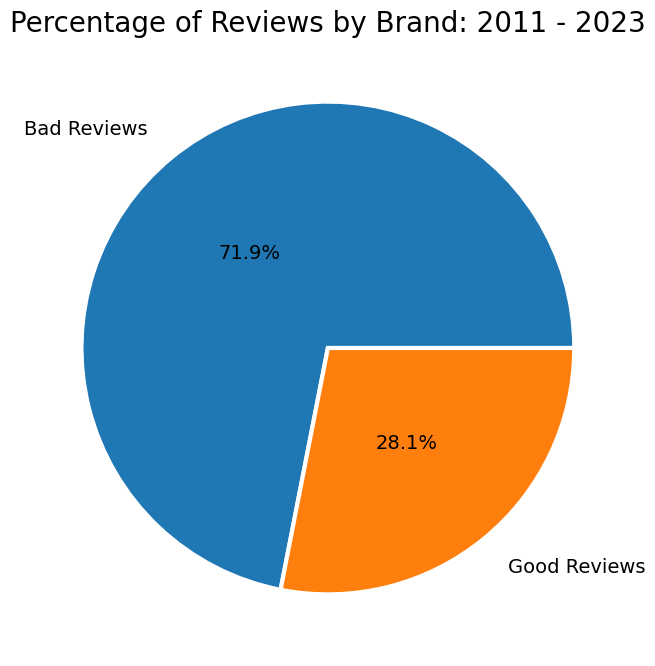

In [212]:
plt.figure(figsize=(8,8))
plt.pie(x=num_of_reviews_percentage, autopct="%.1f%%",
        labels=['Bad Reviews','Good Reviews'], 
        pctdistance=0.5, textprops={'fontsize': 14}, 
        labeldistance=1.15, 
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('Percentage of Reviews by Brand: 2011 - 2023', fontsize=20)
plt.show()

I'm going to run sentiment analysis on the data to see the subjectivity and polarity of each of the reviews.

In [89]:
def findSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def findPolarity(text):
    return TextBlob(text).sentiment.polarity

In [90]:
data['subjectivity'] = data['review'].apply(findSubjectivity)
data['polarity'] = data['review'].apply(findPolarity)
data

,date,rating,body,review,subjectivity,polarity
0,2023-01-08,5.0,great thing british airway economy section ups...,Bad,0.666667,-0.7
1,2023-01-06,1.0,staff friendly plane cold shivering gave light...,Bad,0.666667,-0.7
2,2023-01-02,1.0,probably worst business class experience ive e...,Bad,0.666667,-0.7
3,2023-01-02,2.0,definitely recommended especially business cla...,Bad,0.666667,-0.7
4,2023-01-02,8.0,shuttle service across uk still surprisingly g...,Good,0.600000,0.7
...,...,...,...,...,...,...
3443,2012-08-29,10.0,flew lhr vie return operated bmi aircraft airc...,Good,0.600000,0.7
3444,2012-08-28,9.0,lhr ham purser address club passenger name boa...,Good,0.600000,0.7
3445,2011-10-12,5.0,son worked british airway urged fly british ai...,Bad,0.666667,-0.7
3446,2011-10-11,4.0,london citynew york jfk via shannon really nic...,Bad,0.666667,-0.7


It seems that the sentiment analysis is completely binary and can't accurately portray the diversity of the text in the data. Let's run the sentiment analysis on the pre-data instead.

In [91]:
pre_data['subjectivity'] = pre_data['body'].apply(findSubjectivity)
pre_data['polarity'] = pre_data['body'].apply(findPolarity)
pre_data

,Unnamed: 0,date,rating,body,subjectivity,polarity
0,0,8th January 2023,5.0,Not Verified | Great thing about British Airw...,0.455350,0.075123
1,1,6th January 2023,1.0,Not Verified | The staff are friendly. The pla...,0.507576,-0.087121
2,2,2nd January 2023,1.0,✅ Trip Verified | Probably the worst business ...,0.495903,-0.083001
3,3,2nd January 2023,2.0,"✅ Trip Verified | Definitely not recommended, ...",0.553333,-0.038542
4,4,2nd January 2023,8.0,✅ Trip Verified | BA shuttle service across t...,0.472222,0.322222
...,...,...,...,...,...,...
3443,3443,29th August 2012,10.0,Flew LHR - VIE return operated by bmi but BA a...,0.553902,0.381837
3444,3444,28th August 2012,9.0,LHR to HAM. Purser addresses all club passenge...,0.428571,0.173214
3445,3445,12th October 2011,5.0,My son who had worked for British Airways urge...,0.282222,0.143148
3446,3446,11th October 2011,4.0,London City-New York JFK via Shannon on A318 b...,0.446667,0.351667


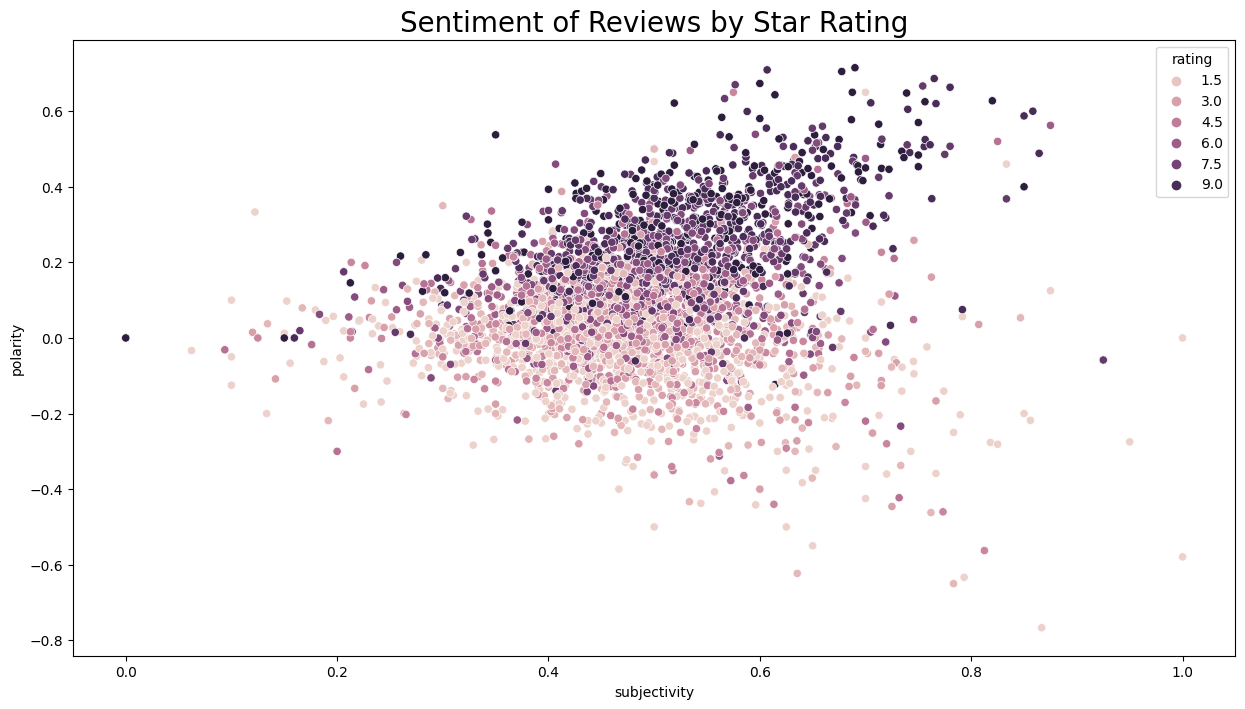

In [211]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='subjectivity', y='polarity', data=pre_data, hue='rating')
sns.color_palette("rocket", as_cmap=True)
plt.title('Sentiment of Reviews by Star Rating', fontsize=20)
plt.show()

We can see that the increase in subjectivity and a decrease in polarity (mostly negative) is aligned with the lower ratings. This is accurate because the lower ratings most likely have negative connotations attached and so the word choice of customers must be horrid. Vice versa, an increase in subjectivity and increase in polarity (positive) is associated with higher ratings; this makes sense as higher reviews will utilize more positive words.

Let's run the sentiment intensity analyzer to see if we can derive any additional information.

In [93]:
sid = SentimentIntensityAnalyzer()
data['scores'] = data['body'].apply(lambda review: sid.polarity_scores(review))
data

,date,rating,body,review,subjectivity,polarity,scores
0,2023-01-08,5.0,great thing british airway economy section ups...,Bad,0.666667,-0.7,"{'neg': 0.099, 'neu': 0.665, 'pos': 0.236, 'co..."
1,2023-01-06,1.0,staff friendly plane cold shivering gave light...,Bad,0.666667,-0.7,"{'neg': 0.077, 'neu': 0.783, 'pos': 0.14, 'com..."
2,2023-01-02,1.0,probably worst business class experience ive e...,Bad,0.666667,-0.7,"{'neg': 0.13, 'neu': 0.841, 'pos': 0.03, 'comp..."
3,2023-01-02,2.0,definitely recommended especially business cla...,Bad,0.666667,-0.7,"{'neg': 0.128, 'neu': 0.648, 'pos': 0.225, 'co..."
4,2023-01-02,8.0,shuttle service across uk still surprisingly g...,Good,0.600000,0.7,"{'neg': 0.052, 'neu': 0.739, 'pos': 0.209, 'co..."
...,...,...,...,...,...,...,...
3443,2012-08-29,10.0,flew lhr vie return operated bmi aircraft airc...,Good,0.600000,0.7,"{'neg': 0.045, 'neu': 0.604, 'pos': 0.351, 'co..."
3444,2012-08-28,9.0,lhr ham purser address club passenger name boa...,Good,0.600000,0.7,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp..."
3445,2011-10-12,5.0,son worked british airway urged fly british ai...,Bad,0.666667,-0.7,"{'neg': 0.071, 'neu': 0.799, 'pos': 0.13, 'com..."
3446,2011-10-11,4.0,london citynew york jfk via shannon really nic...,Bad,0.666667,-0.7,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp..."


A word cloud will be able to show us the most commonly used words. I attemped to derive insight by separating into a positive word cloud and a negative word cloud, but the visual looked about the same. So, it's most likely in the stakeholder's interest to understand what are the most common topics that customers review.

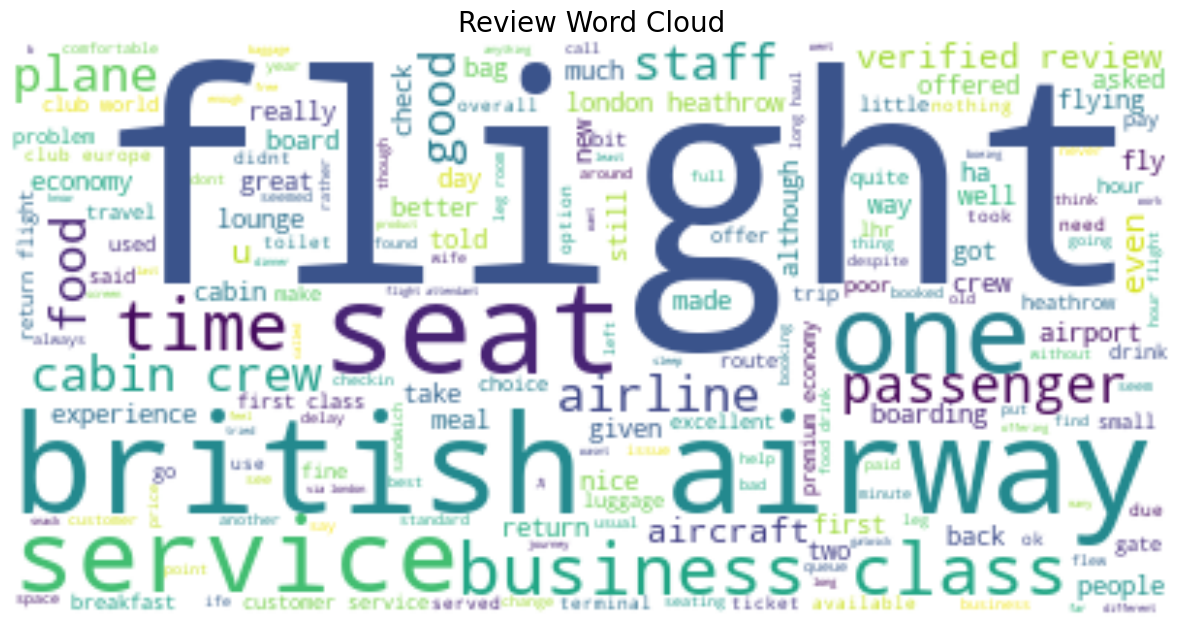

In [99]:
all_words = " ".join([review for review in data['body']])
word_cloud = WordCloud(background_color="white", random_state=1, max_font_size=100).generate(all_words)
plt.figure(figsize=(15, 20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Review Word Cloud", fontsize=20)
plt.show()

I'm also going to do some topic modeling utilizing the TF-IDF Vectorizer method as well as the Count Vectorizer method to see if there are any established groups created amongst the reviews.

In [143]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(data['body']).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [129]:
%%time
# Define Search Param
search_params = {'n_components': [6, 8, 10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(vectors)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [6, 8, 10, 15, 20]})

In [130]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vectors))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 6}
Best Log Likelihood Score:  -50612.52350959089
Model Perplexity:  9796.89959702004


In [131]:
# Tweak the two parameters below
number_topics = 6
number_words = 8

In [135]:
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, learning_decay=0.9)
%timeit lda.fit(vectors)

26 s ± 2.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [136]:
def print_topics(model,n_top_words):
    words = vocab
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [145]:
# Print the topics found by the LDA model
print_topics(lda, number_words)


Topic #0:
ko irritated mykonos spotlessly underwhelmed cello lhrbgo rubbery

Topic #1:
flight seat service good food crew time british

Topic #2:
sofia avianca phased george hesitation insulting lca flowing

Topic #3:
bradford inflated twin brisbane existant economical spinach vaccine

Topic #4:
vegan zagreb catania lhrzrh television kansa zrh complement

Topic #5:
kl luxembourg flightdeck apr kosher applying sicily marrakesh


Given the perplexity is so high along with the log-likelihood score, this model is relatively weak and the topics that were created are not accurately displayed. Let's try the Count Vectorizer method instead.

In [185]:
cvectorizer = CountVectorizer(stop_words='english')
cvectors = vectorizer.fit_transform(data['body']).todense()
cvectors.shape

(3448, 11807)

In [190]:
lda = LDA(n_components=number_topics, n_jobs=-1, learning_decay=0.9)
lda.fit(cvectors)

LatentDirichletAllocation(learning_decay=0.9, n_components=6, n_jobs=-1)

In [191]:
print("Topics found via LDA:")
print_topics(lda, number_words)

Topics found via LDA:

Topic #0:
flight seat service food time british airway good

Topic #1:
cello horrid lhrbgo madlhrjed desing bacardi jaded exhausted

Topic #2:
florence patient porto bug redeem eco fabulous inward

Topic #3:
gluten updating japan ibiza transportation popcorn linate brisbane

Topic #4:
good club seat excellent comfortable lounge crew world

Topic #5:
jersey bilbao diverted mar titan lux eze strolled


Topic 0 and 4 seem relatively useful with positive sentiment attached to both topics. This concludes the end of the data analysis portion of the British Airways task. I will fit some of these visualizations to a presentation slide and then move onto the second task.